In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

In [50]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
        )
        self.fc1 = nn.Linear(32 * 7 * 7, bottleneck_dim)
        self.fc2 = nn.Linear(bottleneck_dim, 32 * 7 * 7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = self.decoder(x)
        return x


In [51]:
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    return images + noise

def calculate_ssim(original, reconstructed):
    original = original.cpu().detach().numpy().squeeze()
    reconstructed = reconstructed.cpu().detach().numpy().squeeze()
    return ssim(original, reconstructed)

In [52]:
def train_model(model, train_loader, test_loader, criterion, optimizer, sigma, num_epochs=10):
    train_losses = []
    test_ssim_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in train_loader:
            images, _ = data
            images_noisy = add_gaussian_noise(images, sigma)
            optimizer.zero_grad()
            outputs = model(images_noisy)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_losses.append(running_loss / len(train_loader.dataset))

        model.eval()
        test_ssim = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, _ = data
                images_noisy = add_gaussian_noise(images, sigma)
                outputs = model(images_noisy)
                test_ssim += calculate_ssim(images, outputs) * images.size(0)
        test_ssim_scores.append(test_ssim / len(test_loader.dataset))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]}, Test SSIM: {test_ssim_scores[-1]}")

    return train_losses, test_ssim_scores

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
sigma_values = [0.1, 0.5, 1.0]
bottleneck_dimensions = [16, 32, 64]
num_epochs = 10

In [55]:
ssim_scores_sigma = []
for sigma in sigma_values:
    model = Autoencoder(bottleneck_dim=32)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_ssim_scores = train_model(model, train_loader, test_loader, criterion, optimizer, sigma, num_epochs)
    ssim_scores_sigma.append(test_ssim_scores)

Epoch [1/10], Loss: 0.027488789606591065, Test SSIM: 0.9175879683487989
Epoch [2/10], Loss: 0.008930360024422407, Test SSIM: 0.9366043960337364
Epoch [3/10], Loss: 0.007466868526985248, Test SSIM: 0.9450535181982561
Epoch [4/10], Loss: 0.006717836944758892, Test SSIM: 0.9498577463770477
Epoch [5/10], Loss: 0.006276888923843702, Test SSIM: 0.9533535595148199
Epoch [6/10], Loss: 0.00598690049747626, Test SSIM: 0.9550265687354397
Epoch [7/10], Loss: 0.0057767703868448735, Test SSIM: 0.956914902212907
Epoch [8/10], Loss: 0.005617882761607567, Test SSIM: 0.9577969420244321
Epoch [9/10], Loss: 0.005494613450517257, Test SSIM: 0.9582528784935755
Epoch [10/10], Loss: 0.0053934963785111905, Test SSIM: 0.9598662781370857
Epoch [1/10], Loss: 0.0361364326318105, Test SSIM: 0.8482738293536412
Epoch [2/10], Loss: 0.016060045475761096, Test SSIM: 0.8772903276852118
Epoch [3/10], Loss: 0.014104641944666704, Test SSIM: 0.8888283609787487
Epoch [4/10], Loss: 0.013293669692675272, Test SSIM: 0.8945918410

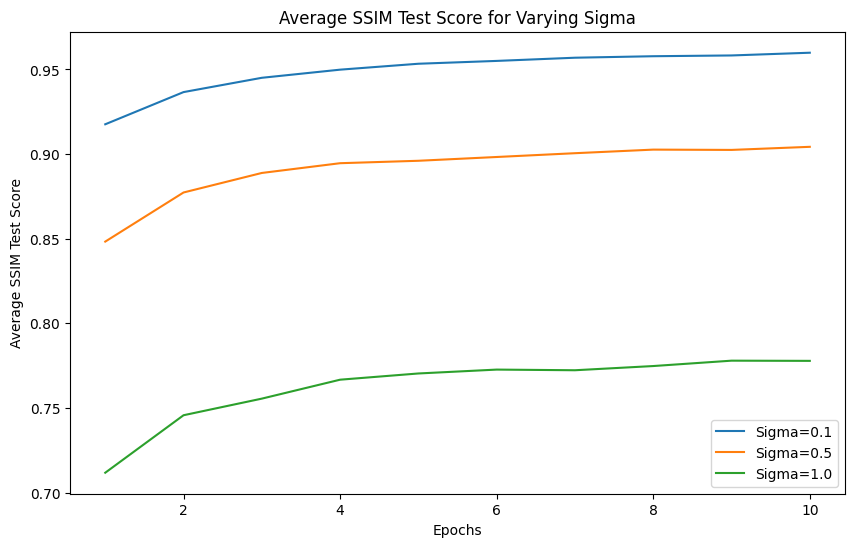

In [56]:
plt.figure(figsize=(10, 6))
for i, sigma in enumerate(sigma_values):
    plt.plot(range(1, num_epochs + 1), ssim_scores_sigma[i], label=f"Sigma={sigma}")
plt.xlabel('Epochs')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score for Varying Sigma')
plt.legend()
plt.show()

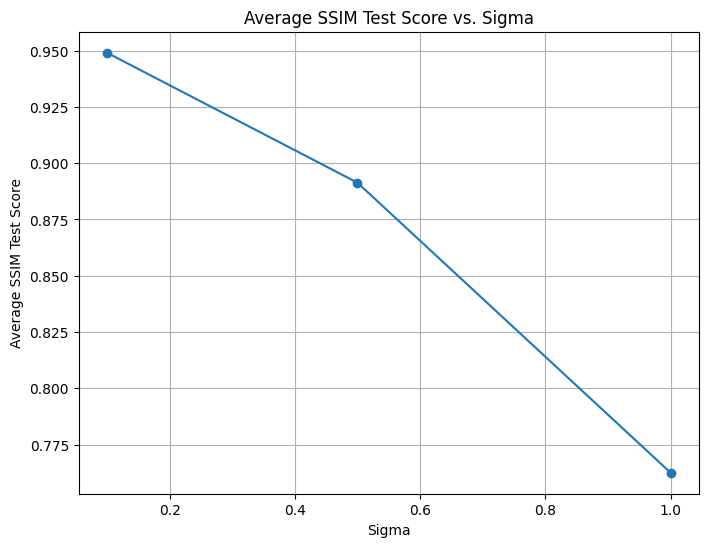

In [58]:
average_ssim_per_sigma = [np.mean(scores[i:i+10]) for scores in ssim_scores_sigma for i in range(0, len(scores), 10)]

plt.figure(figsize=(8, 6))
plt.plot(sigma_values, average_ssim_per_sigma, marker='o')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score vs. Sigma')
plt.grid(True)
plt.show()

**Observations:**
1. The first plot shows how the average SSIM test score changes over a number of epochs for three different values of a parameter sigma. The trend suggests that as the epochs increase, the SSIM test score also increases, indicating that the model's performance is improving with more training. The highest SSIM score is achieved with sigma=0.1, followed by sigma=0.5, and then sigma=1.0. This suggests that a lower sigma value yields better image similarity results, at least up to a sigma of 0.1 in this context.

2. The second plot shows a direct comparison between different sigma values and the SSIM test score, without considering epochs. It illustrates a clear inverse relationship between sigma and the SSIM score: as sigma increases, the SSIM test score decreases. This confirms that increasing the sigma value negatively affects the model's performance in terms of image similarity.

In summary, both plots suggest that a lower sigma value is better for the performance of this model in terms of image similarity as measured by SSIM.

In [57]:
sigma = 0.2
ssim_scores_bottleneck = []
for dim in bottleneck_dimensions:
    model = Autoencoder(bottleneck_dim=dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_ssim_scores = train_model(model, train_loader, test_loader, criterion, optimizer, sigma, num_epochs)
    ssim_scores_bottleneck.append(test_ssim_scores)

Epoch [1/10], Loss: 0.03965986780226231, Test SSIM: 0.8290646022452581
Epoch [2/10], Loss: 0.01796395153403282, Test SSIM: 0.8681952279842952
Epoch [3/10], Loss: 0.015098411235709985, Test SSIM: 0.8847453030064495
Epoch [4/10], Loss: 0.013716786270340283, Test SSIM: 0.8950230991590137
Epoch [5/10], Loss: 0.012931507525841395, Test SSIM: 0.9009518305833574
Epoch [6/10], Loss: 0.012423836378753186, Test SSIM: 0.903611141426936
Epoch [7/10], Loss: 0.012047915653884411, Test SSIM: 0.9068920801621604
Epoch [8/10], Loss: 0.011761815059681734, Test SSIM: 0.9085790642669317
Epoch [9/10], Loss: 0.011530809068183104, Test SSIM: 0.9110418079469157
Epoch [10/10], Loss: 0.011347808142503102, Test SSIM: 0.9114419433932391
Epoch [1/10], Loss: 0.02918971600284179, Test SSIM: 0.9051073132499438
Epoch [2/10], Loss: 0.010399985052645206, Test SSIM: 0.9251522954987075
Epoch [3/10], Loss: 0.008830348468820253, Test SSIM: 0.934622585614596
Epoch [4/10], Loss: 0.008000873258709908, Test SSIM: 0.9397306814575

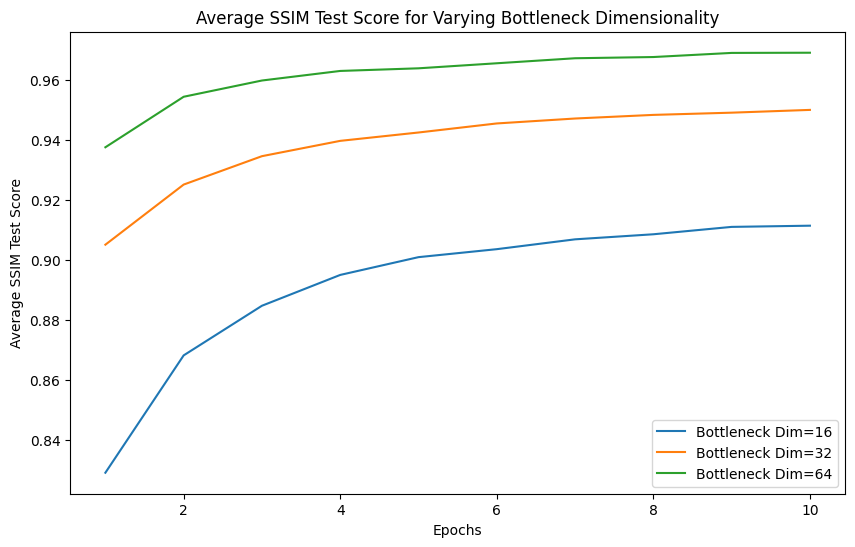

In [59]:
plt.figure(figsize=(10, 6))
for i, dim in enumerate(bottleneck_dimensions):
    plt.plot(range(1, num_epochs + 1), ssim_scores_bottleneck[i], label=f"Bottleneck Dim={dim}")
plt.xlabel('Epochs')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score for Varying Bottleneck Dimensionality')
plt.legend()
plt.show()

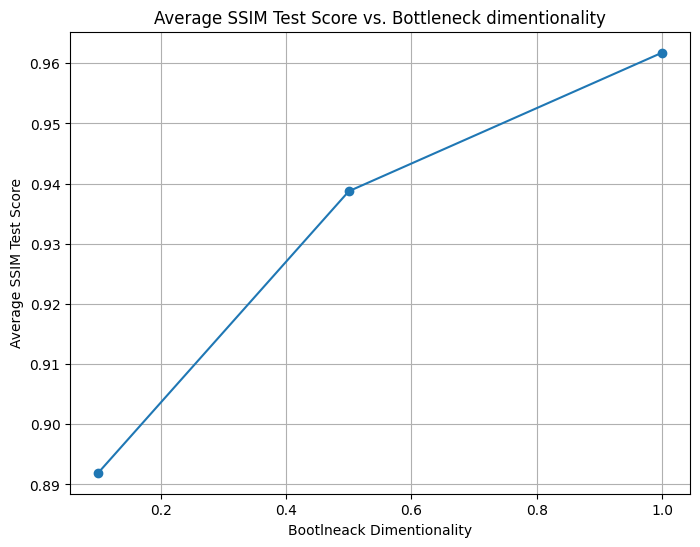

In [61]:
average_ssim_per_dim = [np.mean(scores[i:i+10]) for scores in ssim_scores_bottleneck for i in range(0, len(scores), 10)]

plt.figure(figsize=(8, 6))
plt.plot(sigma_values, average_ssim_per_dim, marker='o')
plt.xlabel('Bootlneack Dimentionality')
plt.ylabel('Average SSIM Test Score')
plt.title('Average SSIM Test Score vs. Bottleneck dimentionality')
plt.grid(True)
plt.show()

**Observations:**

1. The first plot you've shared shows the average SSIM test score over a number of training epochs for three different bottleneck dimensionalities. These dimensionalities are 16, 32, and 64. In this plot, as the number of epochs increases, the SSIM test score also increases for all three bottleneck dimensionalities. This suggests that the model is learning and improving its performance in terms of image similarity as training progresses.

2. The second plot compares the SSIM test score directly against the bottleneck dimensionality. The trend shows a positive correlation between bottleneck dimensionality and the SSIM score: as the bottleneck dimensionality increases, the SSIM score increases.

Larger bottleneck sizes are beneficial for the SSIM performance of the model.